In [1]:
import datetime

import numpy as np
import pandas as pd

FIGURES_PATH = 'out/figures/'
DATASETS_PATH = 'out/datasets/'
CLUSTERS_PATH = 'out/clusters/'
DICTS_PATH = 'out/dicts/'

In [2]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from distances import Distances
from clustering import Clustering, get_dists
import matplotlib.pyplot as plt

tqdm.pandas()
from helper import *

In [3]:
class Tester:
    def __init__(self):
        return


    def dist_between(self, cluster1, cluster2, dists):
        s = 0.0
        cnt = 0
        for i in cluster1:
            for j in cluster2:
                s += self.get_dist(i, j, dists) ** 2
                cnt += 1

        if s == 0:
            return 0.01
        return np.sqrt(s) / cnt


    @staticmethod
    def tp_tn_fp_fn(clusters1, clusters2):
        elements = list(set(np.concatenate(clusters1)))
        cnt = 0
        tp, tn = 0, 0
        fn, fp = 0, 0
        for i in range(len(elements)):
            for j in range(i + 1, len(elements)):

                in_one1 = False
                in_one2 = False

                for c1 in clusters1:
                    if elements[i] in c1 and elements[j] in c1:
                        in_one1 = True
                        break

                for c2 in clusters2:
                    if elements[i] in c2 and elements[j] in c2:
                        in_one2 = True
                        break

                if in_one1 and in_one2:
                    tp += 1

                elif (not in_one1) and (not in_one2):
                    tn += 1

                elif in_one1 and (not in_one2):
                    fn += 1

                elif (not in_one1) and in_one2:
                    fp += 1

                cnt += 1

        return tp, tn, fp, fn

    @staticmethod
    def get_dist(i, j, dists):
        if (i, j) in dists:
            return dists[i, j]

        if (j, i) in dists:
            return dists[j, i]

        return 100

    @staticmethod
    def rand(tp, tn, fp, fn):
        cnt = tp + tn + fp + fn
        return (tp + tn) / cnt

    @staticmethod
    def adjusted_rand(tp, tn, fp, fn):
        n = tp + tn + fp + fn
        return (tp + tn) / n - ((tp + fp) * (tp + fn) + (fn + tn) * (fp + tn)) / (n ** 2)

    @staticmethod
    def fm(tp, tn, fp, fn):
        return tp / np.sqrt((tp + fp) * (tp + fn))

    @staticmethod
    def jaccard(tp, tn, fp, fn):
        return tp / (tp + fp + fn)

    @staticmethod
    def f1(tp, tn, fp, fn):
        p, r = tp / (tp + fp), tp / (tp + fn)
        return 2 * p * r / (p + r)

    @staticmethod
    def cohen(inter, outer):
        mu = np.mean(inter)
        d = np.mean(outer)
        return (mu - d) / (max(mu, d))


    def silhouette(self, clusters, dists):
        s = dict()
        for i1 in range(len(clusters)):
            closest_cluster = i1
            min_d = np.inf

            for i2 in range(len(clusters)):
                if i2 == i1:
                    continue
                d = self.dist_between(clusters[i1], clusters[i2], dists)
                if d < min_d:
                    min_d = d
                    closest_cluster = i2


            for j in range(len(clusters[i1])):
                sum = 0.0
                cnt = 0.0
                for j1 in range(len(clusters[i1])):
                    if j != j1:
                        sum += self.get_dist(clusters[i1][j], clusters[i1][j1], dists)
                        cnt += 1

                aj = sum / cnt
                sum = 0.0
                cnt = 0.0
                for j1 in range(len(clusters[closest_cluster])):
                    sum += self.get_dist(clusters[i1][j], clusters[closest_cluster][j1], dists)
                    cnt += 1

                bj = sum / cnt

                s[clusters[i1][j]] = (bj - aj) / max(bj, aj)

        return s

    def inter(self, clusters, dists):
        res = []
        for cluster in clusters:
            s = 0.0
            cnt = 0
            for i in range(len(cluster)):
                for j in range(i + 1, len(cluster)):
                    s += self.get_dist(i, j, dists) ** 2
                    cnt += 1
            if cnt == 0:
                res.append(s)
            else:
                res.append(np.sqrt(s) / cnt)
        return res

    def outer(self, clusters, dists):
        outer = np.full((len(clusters), len(clusters)), 0)
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                outer[i, j] = self.dist_between(clusters[i], clusters[j], dists)
                outer[j, i] = outer[i, j]

        return outer


    @staticmethod
    def dbi(inter, outer):
        s = 0.0
        for i in range(len(inter)):
            max = -np.inf
            for j in range(len(inter)):
                if i != j:
                    dbi = (inter[i] + inter[j]) / (outer[i, j] + 1)
                    if dbi > max:
                        max = dbi
            s += max
        return s / len(inter)



    @staticmethod
    def plot(stats):
        names = list(stats.keys())
        renaming = {
            'silhouette': 'Индекс силуэта',
            'dbi': 'Индекс Дэвиса-Болдина',
            'cohen': 'Cohen\'s Index',
            'jaccard': 'Коэффициент Жаккара',
            'fm': 'Индекс Фоулкса-Мэлловса',
            'rand': 'Индекс Рэнда',
            'adjusted_rand': 'Adjusted Rand Index',
            'wss': 'Компактность кластеров',
            'bss': 'Отделимость кластеров',
            'f1': 'F1-score'
        }
        renaming_names = {
            'average': 'среднесвязный',
            'max_dist': 'полносвязный',
            'min_dist': 'односвязный',
            'weighted': 'взвешенный',
            'ward': 'Варда',
            'k_means': 'k-средних',
        }
        optimal = {
            'silhouette': 1,
            'dbi': 0,
            'cohen': 1,
            'jaccard': 1,
            'fm': 1,
            'rand': 1,
            'adjusted_rand': 1,
            'wss': 0,
            'bss': 100,
            'f1': 1
        }

        for metric in ['jaccard', 'fm', 'rand', 'adjusted_rand', 'f1']:
            values = []
            names_2 = []
            for n in names:
                values.append(stats[n][metric])
                names_2.append(renaming_names[n])
            plt.figure(figsize=(5, 5))
            plt.grid(zorder=0)
            plt.title(label=renaming[metric])
            plt.bar(names_2, values)
            plt.axhline(optimal[metric], color='red', label='Идеальное', linestyle='--')
            plt.xticks(rotation=45)
            plt.xlabel('Метод')
            plt.ylabel('Оценка')
            plt.legend(loc=2)
            plt.savefig(FIGURES_PATH + '___' + metric, bbox_inches='tight')

        for metric in ['silhouette', 'dbi', 'wss', 'bss']:
            values1, values2 = [], []
            names_2 = []
            for n in names:
                values1.append(stats[n][metric][0])
                values2.append(stats[n][metric][1])
                names_2.append(renaming_names[n])

            for i, b in enumerate(np.isnan(values2)):
                if b:
                    values2[i] = values1[i]

            if metric == 'silhouette':
                values1 = [v + 0.2 for v in values1]
                values2 = [v + 0.2 for v in values2]
            elif metric == 'cohen':
                values1 = [v + 0.2 for v in values1]
                values2 = [v + 0.2 for v in values2]
            elif metric == 'wss':
                values1 = [v - 20 for v in values1]
                values2 = [v - 20 for v in values2]
            elif metric == 'bss':
                values1 = [v + 20 for v in values1]
                values2 = [v + 20 for v in values2]

            plt.figure(figsize=(5, 5))
            plt.grid(zorder=0)
            plt.title(label=renaming[metric])

            names_axis = np.arange(len(names))
            plt.bar(names_axis - 0.2, values1, 0.4, label='Первый набор данных')
            plt.bar(names_axis + 0.2, values2, 0.4, label='Второй набор данных')
            plt.xticks(names_axis, names_2, rotation=45)
            # plt.bar(names, values)
            plt.axhline(optimal[metric], color='red', label='Идеальное', linestyle='--')
            plt.xlabel('Метод')
            plt.ylabel('Оценка')
            plt.legend(loc=2)
            plt.savefig(FIGURES_PATH + '___' + metric, bbox_inches='tight')

        plt.figure(figsize=(10, 5))
        plt.title(label='Minimal distances between clusters')
        for n in names:
            min_dists = stats[n]['statistics']['min_distances']
            plt.plot(min_dists, label=n)
        plt.legend(loc=2)
        plt.xlabel('Iteration')
        plt.ylabel('Minimal distance')
        plt.savefig(FIGURES_PATH + '___' + 'min_dists', bbox_inches='tight')

        plt.figure(figsize=(5, 5))
        plt.title(label='Time of clustering')
        times = []
        for n in names:
            times.append(stats[n]['statistics']['time_of_all'].seconds)
        plt.grid(zorder=0)
        plt.bar(names, times)
        plt.xticks(rotation=45)
        plt.xlabel('Method')
        plt.ylabel('Time, seconds')
        plt.legend(loc=2)
        plt.savefig(FIGURES_PATH + '___' + 'time_of_clustering', bbox_inches='tight')


        plt.figure(figsize=(10, 5))
        plt.title(label='Times of iterations')
        for n in names:
            times = stats[n]['statistics']['time_of_iter']
            if len(times) != 0:
                if type(times[0]) != int:
                    for i in range(len(times)):
                        times[i] = times[i].microseconds
                plt.plot(times, label=n)
        plt.legend(loc=2)
        plt.xlabel('Iteration')
        plt.ylabel('Time, microseconds')
        plt.savefig(FIGURES_PATH + '___' + 'times', bbox_inches='tight')

    @staticmethod
    def print_result(stats):
        print('Optimal:')
        print(f'\tsilhouette: 1\n\tdbi: min\n\tcohen: 1\n\tjaccard: 1\n\tfm: max\n\trand: 1\n\tadjusted_rand: 1\n\twss: 0\n\tbss: max\n\tf1: 1')

        for method in list(stats.keys()):
            print(f'Method: {method}')
            for metric in ['jaccard', 'fm', 'rand', 'wss', 'bss', 'silhouette', 'cohen', 'dbi']:
                print(f'\t{metric}: {stats[method][metric]}')


    def run_statistics(self,
                       path: str = 'data_processed',
                       nrows: int = 1_000_000,
                       top_lim: int = 1_000,
                       k: int = 100,
                       methods: list[str] = None,
                       field: str = 'product_id'
                       ):

        data = pd.read_csv(DATASETS_PATH + path + '.csv', nrows=2 * nrows).drop(columns=['Unnamed: 0'])
        x_train, x_test = train_test_split(data, test_size=0.5)
        d1 = Distances(data=x_train, nrows=nrows)
        d2 = Distances(data=x_test, nrows=nrows)

        print(f'Collecting data for first...')
        pp1 = d1.get_pp(top_lim=top_lim, batch_size=100_000, field=field)
        print(f'Collecting data for second...')
        pp2 = d2.get_pp(top_lim=top_lim, batch_size=100_000, field=field)

        stats = dict()
        if methods is None:
            methods = ['min_dist', 'max_dist', 'average', 'weighted', 'ward', 'k_means']

        print(f'Starting agglomerative clustering with \n\tfile: {path},\n\tfield: {field},\n\tnrows: {nrows},\n\ttop_lim: {top_lim}')

        for m in methods:
            c = Clustering(get_dists=get_dists)
            print(f'Clustering with method {m}')
            clusters1, dists1 = c.fit(metric='euclidean', method=m, top_lim=top_lim, k=k, dists=pp1)
            clusters2, dists2 = c.fit(metric='euclidean', method=m, top_lim=top_lim, k=k, dists=pp2)

            stats[m] = dict()
            i, o = self.inter(clusters1, dists1), self.outer(clusters1, dists1)
            i2, o2 = self.inter(clusters2, dists2), self.outer(clusters2, dists2)

            stats[m]['inter'], stats[m]['outer'] = [i, i2], [o, o2]
            stats[m]['wss'] = [np.mean(i), np.mean(i2)]
            stats[m]['bss'] = [np.mean(o), np.mean(o2)]
            stats[m]['cohen'], stats[m]['dbi'] = [self.cohen(i, o), self.cohen(i2, o2)], [self.dbi(i, o), self.dbi(i2, o2)]
            stats[m]['silhouette'] = [np.mean(list(self.silhouette(clusters1, dists1).values())), np.mean(list(self.silhouette(clusters2, dists2).values()))]

            tp, tn, fp, fn = self.tp_tn_fp_fn(clusters1, clusters2)

            stats[m]['TP'], stats[m]['TN'], stats[m]['FP'], stats[m]['FN'] = tp, tn, fp, fn
            stats[m]['f1'] = self.f1(tp, tn, fp, fn)
            stats[m]['rand'] = self.rand(tp, tn, fp, fn)

            stats[m]['jaccard'], stats[m]['adjusted_rand'], stats[m]['fm'] = self.jaccard(tp, tn, fp, fn), self.adjusted_rand(tp, tn, fp, fn), self.fm(tp, tn, fp, fn)

            stats[m]['statistics'] = c.get_stats()


        return stats

In [4]:
t = Tester()
stats = t.run_statistics(nrows=1_000_000, top_lim=1000, k=200)

Top of dataset length: 325203
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


  0%|          | 0/4 [00:00<?, ?it/s]

Top of dataset length: 325568
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


  0%|          | 0/4 [00:00<?, ?it/s]

Starting agglomerative clustering with 
	file: data_processed,
	field: product_id,
	nrows: 1000000,
	top_lim: 1000
Clustering with method min_dist
Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Clustering with method max_dist
Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Clustering with method average
Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Clustering with method weighted
Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Clustering with method ward
Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Starting counting distances between clusters...


  0%|          | 0/1073 [00:00<?, ?it/s]

Starting collapsing closest clusters...


  0%|          | 0/873 [00:00<?, ?it/s]

Clustering with method k_means


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


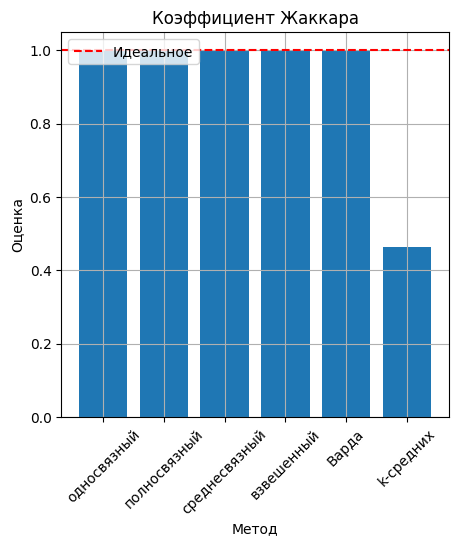

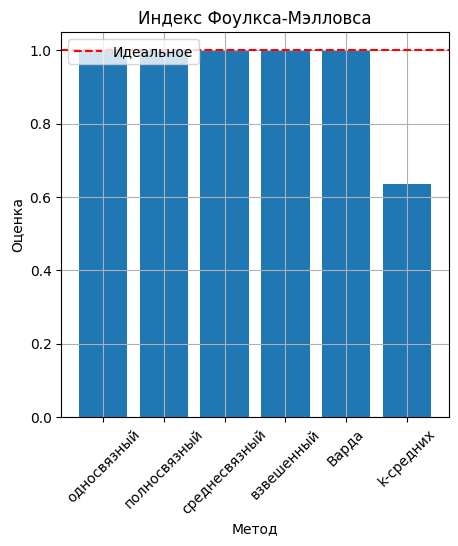

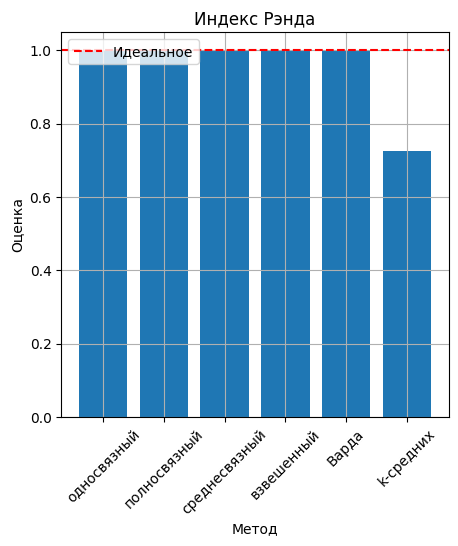

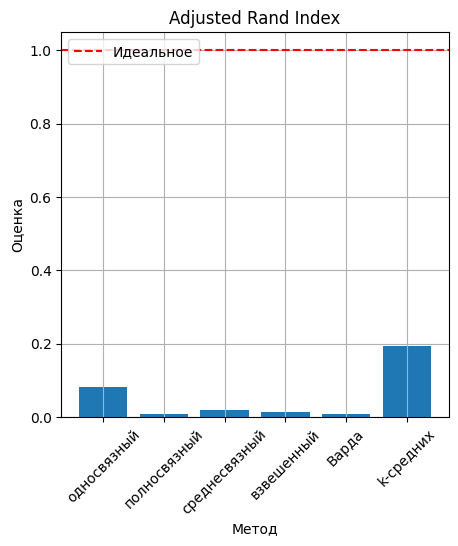

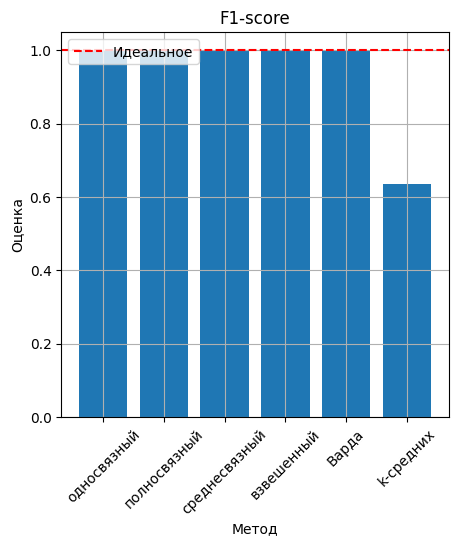

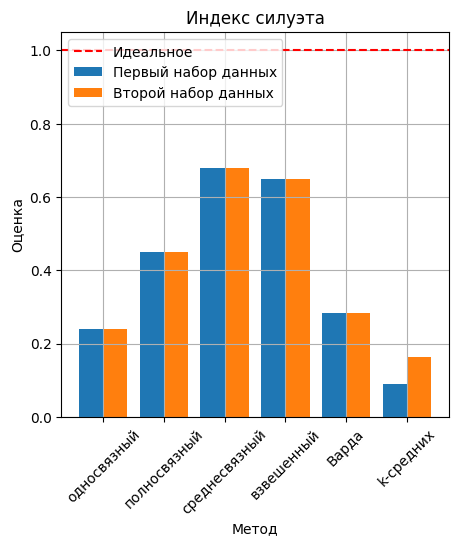

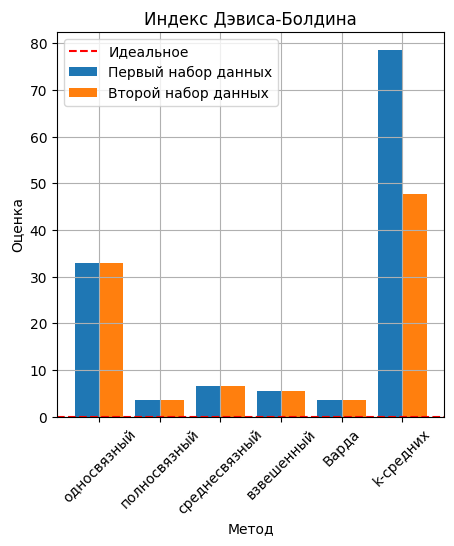

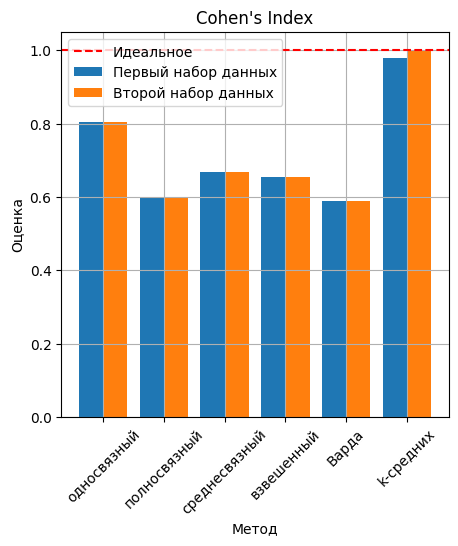

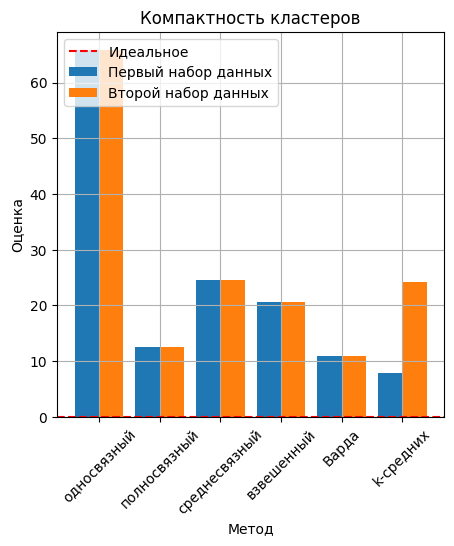

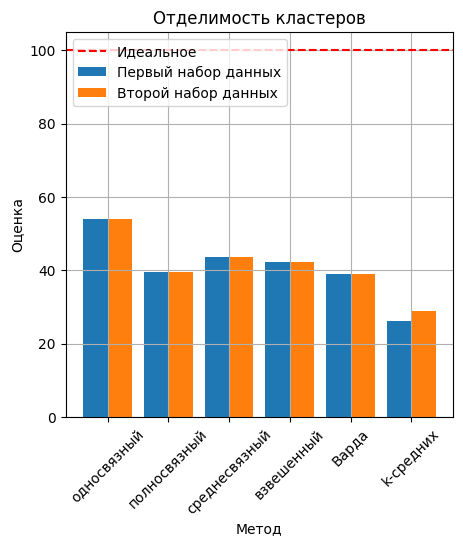

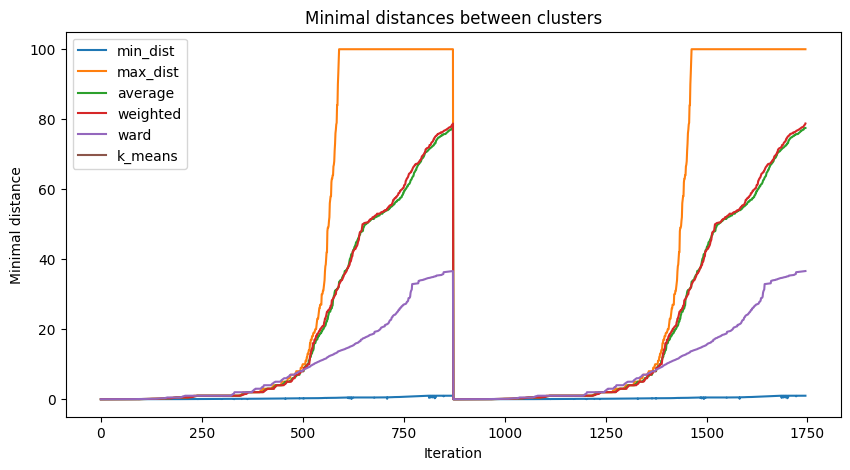

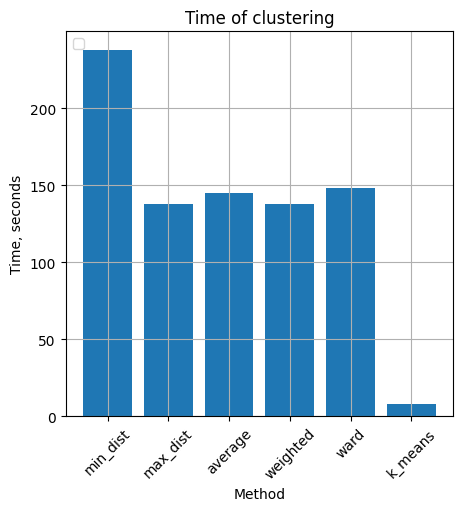

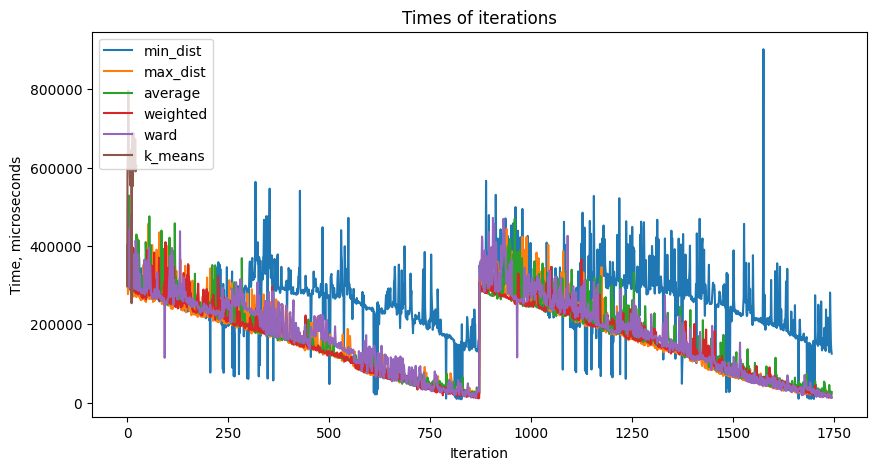

In [5]:
t = Tester()
t.plot(stats)

In [6]:
t.print_result(stats)

Optimal:
	silhouette: 1
	dbi: min
	cohen: 1
	jaccard: 1
	fm: max
	rand: 1
	adjusted_rand: 1
	wss: 0
	bss: max
	f1: 1
Method: min_dist
	jaccard: 1.0
	fm: 1.0
	rand: 1.0
	wss: [85.78986552189082, 85.78986552189082]
	bss: [33.98, 33.98]
	silhouette: [0.03891376491572593, 0.03891376491572593]
	cohen: [0.6039159195169808, 0.6039159195169808]
	dbi: [32.94402125092908, 32.94402125092908]
Method: max_dist
	jaccard: 1.0
	fm: 1.0
	rand: 1.0
	wss: [32.49325787642276, 32.49325787642276]
	bss: [19.6117, 19.6117]
	silhouette: [0.2509812326794353, 0.2509812326794353]
	cohen: [0.39643786798521274, 0.39643786798521274]
	dbi: [3.6807641773902846, 3.6807641773902846]
Method: average
	jaccard: 1.0
	fm: 1.0
	rand: 1.0
	wss: [44.55792393917897, 44.55792393917897]
	bss: [23.65491124260355, 23.65491124260355]
	silhouette: [0.4801619735416697, 0.4801619735416697]
	cohen: [0.4691199869434622, 0.4691199869434622]
	dbi: [6.649357606585124, 6.649357606585124]
Method: weighted
	jaccard: 1.0
	fm: 1.0
	rand: 1.0
	wss

In [7]:
stats['k_means']

{'inter': [[11.237424643755606,
   4.010408892547828,
   2.5129255488107574,
   16.433567198511952,
   12.199423540146373,
   1.0168752722499264,
   21.295913270077495,
   100.0,
   57.735026918962575,
   6.736450178639786,
   57.735026918962575,
   14.701251674349436,
   5.4538072632471,
   57.735026918962575,
   3.9247772835465,
   100.0,
   0.27562354460706173],
  [0.8295533193363791,
   0.21681927708959908,
   100.0,
   100.0,
   57.735026918962575,
   18.55770514946452,
   100.0,
   16.433567198511952,
   4.146950015624749]],
 'outer': [array([[ 0,  4,  3,  8,  8,  2,  9, 19, 13,  6, 15,  9,  5, 15,  4,  2,
           1],
         [ 4,  0,  2,  5,  5,  1,  6, 10,  7,  3,  8,  4,  3,  4,  2,  1,
           0],
         [ 3,  2,  0,  4,  3,  1,  4, 10,  3,  2,  6,  3,  2,  2,  2,  0,
           0],
         [ 8,  5,  4,  0,  9,  2, 13, 23,  8,  7, 17,  9,  6,  8,  5,  3,
           1],
         [ 8,  5,  3,  9,  0,  2, 13, 20, 14,  6, 17,  8,  5, 12,  4,  1,
           1],
         

In [ ]:
stats_old = {
    'jaccard': {'min_dist': 1, 'max_dist': 1, 'average': 1, 'weighted': 1, 'ward': 1, 'k_means': 0.3},
    'fm': {'min_dist': 1, 'max_dist': 1, 'average': 1, 'weighted': 1, 'ward': 1, 'k_means': 0.46},
    'rand': {'min_dist': 1, 'max_dist': 1, 'average': 1, 'weighted': 1, 'ward': 1, 'k_means': 0.87},
    # 'adjusted_rand': {'min_dist': [], 'max_dist': [], 'average': [], 'weighted': [], 'ward': [], 'k_means': []},
    # 'f1': {'min_dist': [], 'max_dist': [], 'average': [], 'weighted': [], 'ward': [], 'k_means': []},
    'silhouette': {'min_dist': [0.28, 0.28], 'max_dist': [0.5, 0.5], 'average': [0.79, 0.79], 'weighted': [0.74, 0.74], 'ward': [0.21, 0.21], 'k_means': [0.2, 0.23]},
    'dbi': {'min_dist': [32.6, 32.6], 'max_dist': [4.0, 4.0], 'average': [10.4, 10.4], 'weighted': [6.5, 6.5], 'ward': [4.0, 4.0], 'k_means': [117, 112]},
    'wss': {'min_dist': [59, 59], 'max_dist': [12, 12], 'average': [26, 26], 'weighted': [24, 24], 'ward': [13, 13], 'k_means': [42, 0.39]},
    'bss': {'min_dist': [53, 53], 'max_dist': [38, 38], 'average': [44, 44], 'weighted': [42, 42], 'ward': [38, 38], 'k_means': [39, 37]},
}